In [1]:
import xarray as xr

In [2]:
chirps1 = xr.open_rasterio('/home/jovyan/development/training_data/CHPclim_jan_jun_cumulative_rainfall.nc')

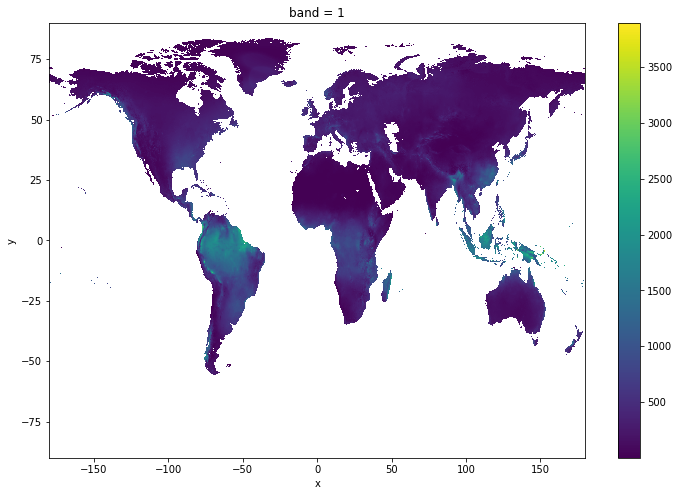

In [3]:
chirps1.squeeze().plot.imshow(figsize=(12,8))

In [4]:
chirps2 = xr.open_rasterio('/home/jovyan/development/training_data/CHPclim_jul_dec_cumulative_rainfall.nc')

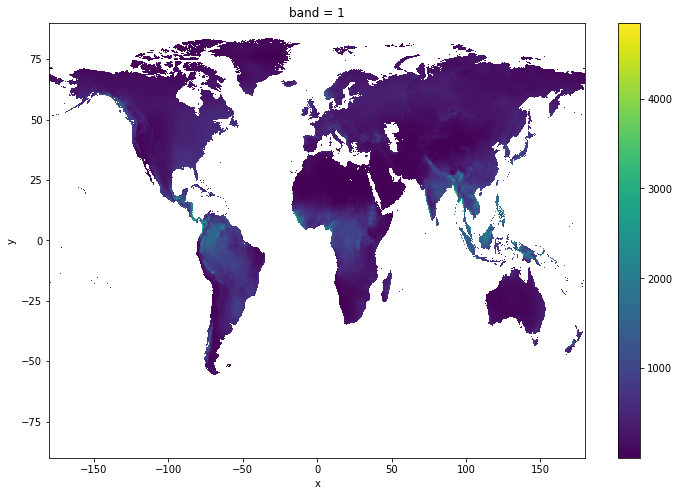

In [5]:
chirps2.squeeze().plot.imshow(figsize=(12,8))

In [6]:
chirps1

<xarray.DataArray (band: 1, y: 3600, x: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 89.97 89.92 89.87 89.82 ... -89.83 -89.88 -89.93 -89.98
  * x        (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9 180.0
Attributes:
    transform:   (0.05000000074505806, 0.0, -180.0, 0.0, -0.05000000074505806...
    res:         (0.05000000074505806, 0.05000000074505806)
    is_tiled:    0
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [2]:
import sys
import os
import matplotlib.pyplot as plt
import pickle
import numpy as np 
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, f_classif
from sklearn.metrics import f1_score, balanced_accuracy_score
import joblib
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from itertools import compress
sys.path.append('/home/jovyan/Scripts')
from dea_classificationtools import spatial_clusters, SKCV, spatial_train_test_split

# Set up working dir
working_dir = '/home/jovyan/development/training_data/2015_merged//'
filename = os.path.join(working_dir, '2015_training_data_binary.txt')
model_input = np.loadtxt(filename, skiprows=1)
random_state = 1234
ncpus = 48

coordinates = model_input[:,-3:-1]

# Set up header and input features
with open(filename, 'r') as file:
    header = file.readline()
column_names = header.split()

column_names_indices = {}

for col_num, var_name in enumerate(column_names):
    column_names_indices[var_name] = col_num

model_variables = ['blue','red','green','nir','swir1','swir2','edev','sdev','bcdev', 'NDVI', 'MNDWI', 'BAI', 'BUI', 'BSI', 'TCG', 'TCW', 'TCB', 'NDMI', 'LAI', 'EVI', 'AWEI_sh', 'BAEI', 'NDSI', 'SAVI', 'NBR', 'BS_PC_10', 'PV_PC_10', 'NPV_PC_10' ,'BS_PC_50', 'PV_PC_50' ,'NPV_PC_50' ,'BS_PC_90', 'PV_PC_90', 'NPV_PC_90', 'chirps']

model_col_indices = []

for model_var in model_variables:
    model_col_indices.append(column_names_indices[model_var])

# Seperate dependent and independent variables
X = model_input[:,model_col_indices]
y = model_input[:,-1]
        
# Spatial k fold
outer_cv_splits = 1
inner_cv_splits = 1
test_size = 0.20
cluster_method = 'Hierarchical'
max_distance = 50000
n_clusters=None
kfold_method = 'SpatialKFold'
balance = 10
# Choose metric that reflects the tradeoffs desired in product
metric='f1'


In [2]:
feature_selection = SelectKBest(f_classif, k="all")

selected = np.array(model_variables)[feature_selection.fit(X,y).get_support()]

print(selected)


['blue' 'red' 'green' 'nir' 'swir1' 'swir2' 'edev' 'sdev' 'bcdev' 'NDVI'
 'MNDWI' 'BAI' 'BUI' 'BSI' 'TCG' 'TCW' 'TCB' 'NDMI' 'LAI' 'EVI' 'AWEI_sh'
 'BAEI' 'NDSI' 'SAVI' 'NBR' 'BS_PC_10' 'PV_PC_10' 'NPV_PC_10' 'BS_PC_50'
 'PV_PC_50' 'NPV_PC_50' 'BS_PC_90' 'PV_PC_90' 'NPV_PC_90' 'chirps']


In [3]:
from sklearn.linear_model import LassoCV, LogisticRegression

In [4]:
from sklearn.feature_selection import RFECV

In [42]:
log = LogisticRegression(penalty='none',max_iter=10000, n_jobs=55).fit(X, y)

In [46]:
log.coef_

array([[-4.92577591e-03, -1.75106751e-02,  1.53115868e-02,
         6.39764109e-03, -5.55000953e-03,  4.99902790e-03,
         2.28738375e-01, -2.39385102e-03,  2.06000152e-02,
        -1.22046449e+00,  9.33048090e-01,  5.34750268e-03,
         1.59450652e+00,  1.76311132e-01,  1.53912776e-02,
        -5.65731991e-04,  1.86477206e-03, -3.82716771e-01,
        -5.54851587e-01, -2.22016055e-01, -1.46896034e-02,
        -5.50566867e+00,  9.33048090e-01, -3.02760149e-01,
        -9.96207476e-01,  6.80829317e-02, -8.73218649e-02,
         5.21645756e-02,  3.54210319e-02, -1.05515012e-01,
        -7.37671415e-02,  2.15195872e-02,  1.40969411e-01,
         8.13220545e-02, -1.63148958e-04]])

In [9]:
selector = RFECV(log, step=1, cv=5, n_jobs=1)
selector = selector.fit(X, y)

/env/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [19]:
list(selector.support_)

[False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False]

In [21]:
model_variables[list(selector.support_)]

TypeError: list indices must be integers or slices, not list

In [31]:
selector.grid_scores_

array([0.92382999, 0.93099892, 0.93565009, 0.93468999, 0.93605553,
       0.94087737, 0.94559253, 0.94580588, 0.94706468, 0.946958  ,
       0.94680866, 0.94668065, 0.94614726, 0.9477261 , 0.94896357,
       0.95128926, 0.95310279, 0.95120392, 0.9525908 , 0.954255  ,
       0.95291088, 0.95423369, 0.95636725, 0.95666595, 0.95598318,
       0.95570579, 0.95487371, 0.95589798, 0.95534321, 0.95212157,
       0.95203622, 0.95267628, 0.95271888, 0.95220682, 0.95256959])

In [6]:
lasso = LassoCV( max_iter=10000, n_jobs=-1).fit(X, y)

In [34]:
importance

array([0.92382999, 0.93099892, 0.93565009, 0.93468999, 0.93605553,
       0.94087737, 0.94559253, 0.94580588, 0.94706468, 0.946958  ,
       0.94680866, 0.94668065, 0.94614726, 0.9477261 , 0.94896357,
       0.95128926, 0.95310279, 0.95120392, 0.9525908 , 0.954255  ,
       0.95291088, 0.95423369, 0.95636725, 0.95666595, 0.95598318,
       0.95570579, 0.95487371, 0.95589798, 0.95534321, 0.95212157,
       0.95203622, 0.95267628, 0.95271888, 0.95220682, 0.95256959])

In [37]:
feature_names[selector.support_]

array(['red', 'edev', 'bcdev', 'NDVI', 'MNDWI', 'BUI', 'BSI', 'NDMI',
       'LAI', 'EVI', 'AWEI_sh', 'BAEI', 'NDSI', 'SAVI', 'NBR', 'BS_PC_10',
       'PV_PC_10', 'NPV_PC_10', 'BS_PC_50', 'PV_PC_50', 'NPV_PC_50',
       'BS_PC_90', 'PV_PC_90', 'NPV_PC_90'], dtype='<U9')

In [35]:
selector.ranking_

array([ 4,  1,  2,  3,  5,  7,  1,  9,  1,  1,  1,  8,  1,  1,  6, 11, 10,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       12])

ConversionError: Failed to convert value(s) to axis units: array(['blue', 'red', 'green', 'nir', 'swir1', 'swir2', 'edev', 'sdev',
       'bcdev', 'NDVI', 'MNDWI', 'BAI', 'BUI', 'BSI', 'TCG', 'TCW', 'TCB',
       'NDMI', 'LAI', 'EVI', 'AWEI_sh', 'BAEI', 'NDSI', 'SAVI', 'NBR',
       'BS_PC_10', 'PV_PC_10', 'NPV_PC_10', 'BS_PC_50', 'PV_PC_50',
       'NPV_PC_50', 'BS_PC_90', 'PV_PC_90', 'NPV_PC_90', 'chirps'],
      dtype='<U9')

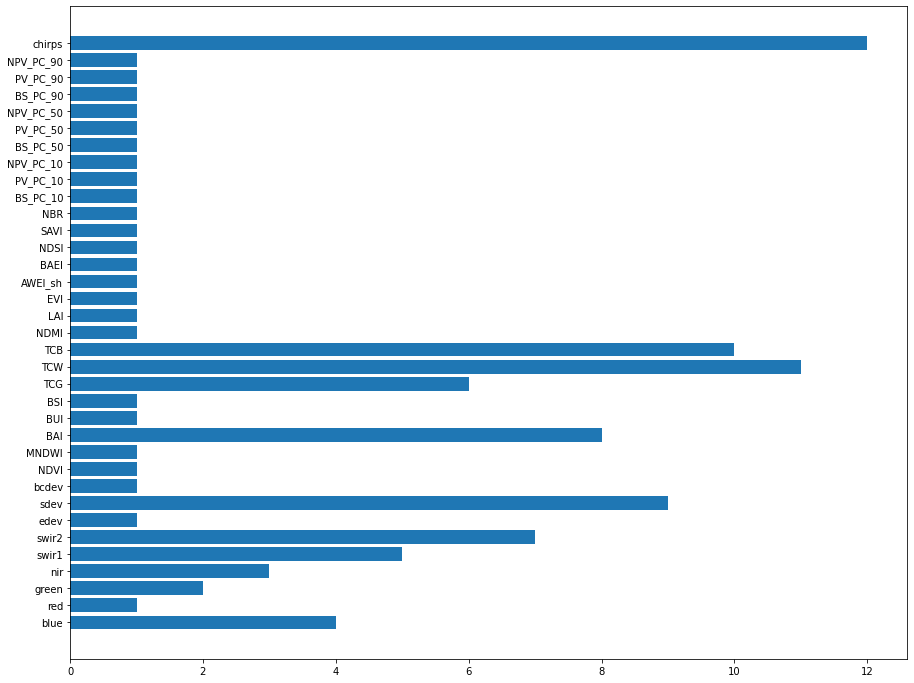

In [40]:
importance = np.abs(selector.ranking_)
feature_names = np.array(model_variables)
from matplotlib.pyplot import figure, xticks

figure(figsize=(15, 12))
plt.barh(width=importance, y=feature_names)
xticks(feature_names, rotation='vertical')
plt.title("Feature importances via coefficients")
plt.show()

In [41]:
log.coef_

array([[-4.95558136e-03, -1.73022144e-02,  1.53106765e-02,
         6.25684352e-03, -5.47906645e-03,  4.93978864e-03,
         1.59851305e-01, -5.20236896e-03, -3.29324677e-02,
        -1.16554043e+00,  8.52041999e-01,  5.24486876e-03,
         1.57474713e+00,  2.27812736e-01,  1.05614975e-02,
        -7.93220557e-04,  1.01037712e-03, -4.15870723e-01,
        -5.32549252e-01, -2.10849579e-01, -9.41589159e-03,
        -5.40426586e+00,  8.52041999e-01, -2.92592429e-01,
        -9.70479455e-01,  6.61228273e-02, -8.44859874e-02,
         5.00993553e-02,  3.14732047e-02, -1.06277260e-01,
        -7.48944024e-02,  2.30979189e-02,  1.39178056e-01,
         7.97940975e-02, -1.88520062e-04]])

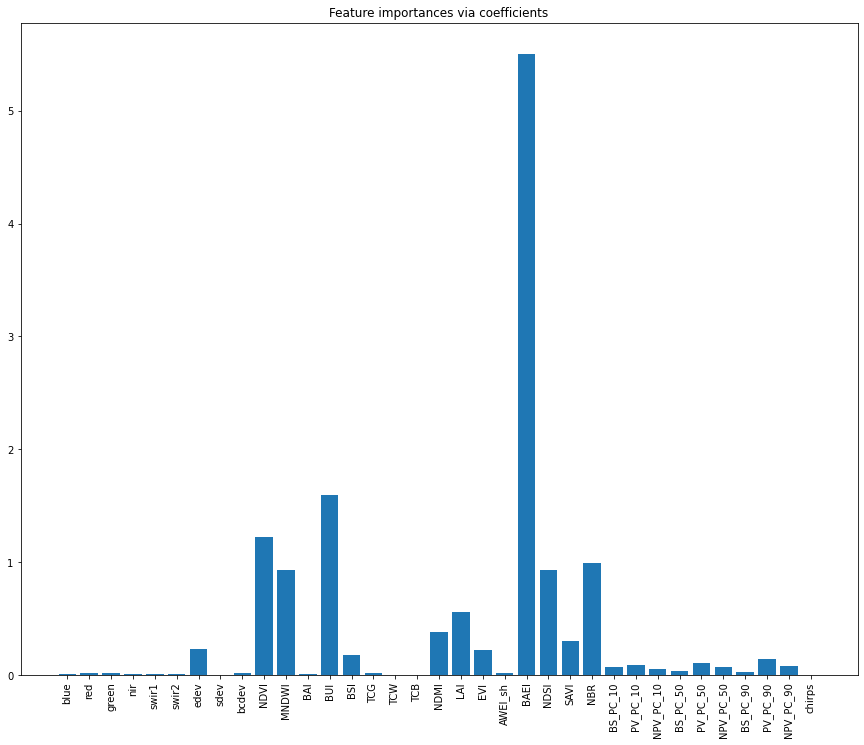

In [47]:
importance = np.abs(log.coef_)
feature_names = np.array(model_variables)
from matplotlib.pyplot import figure, xticks

figure(figsize=(15, 12))
plt.bar(height=importance[0], x=feature_names)
xticks(feature_names, rotation='vertical')
plt.title("Feature importances via coefficients")
plt.show()

In [12]:
from matplotlib.pyplot import xticks

['blue' 'red' 'green' 'nir' 'swir1' 'swir2' 'edev' 'sdev' 'bcdev' 'NDVI'
 'MNDWI' 'BAI' 'BUI' 'BSI' 'TCG' 'TCW' 'TCB' 'NDMI' 'LAI' 'EVI' 'AWEI_sh'
 'BAEI' 'NDSI' 'SAVI' 'NBR' 'BS_PC_10' 'PV_PC_10' 'NPV_PC_10' 'BS_PC_50'
 'PV_PC_50' 'NPV_PC_50' 'BS_PC_90' 'PV_PC_90' 'NPV_PC_90' 'chirps']
_SpatialKFold(balance=10,
       coordinates=array([[  390675., -2004150.],
       [  377085., -2010975.],
       ...,
       [  941430., -3597135.],
       [  939915., -3597105.]]),
       max_distance=50000, method='Hierarchical', n_groups=None,
       n_splits=2, random_state=None, shuffle=True, test_size=0.2,
       train_size=None)
=== Nested Spatial K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.9
Std balanced accuracy: 0.05
Mean F1: 0.87
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Number of features: 35 / 35
blue: 0.009685
red: 0.02087
green: 0.03566
nir: 0.03013
swir1: 0.01666
swir2: 0.02178
edev: 0.08554
sdev: 0.02743
bcdev: 0.03285
NDVI: 0.0213
MNDWI: 0.01948
BAI

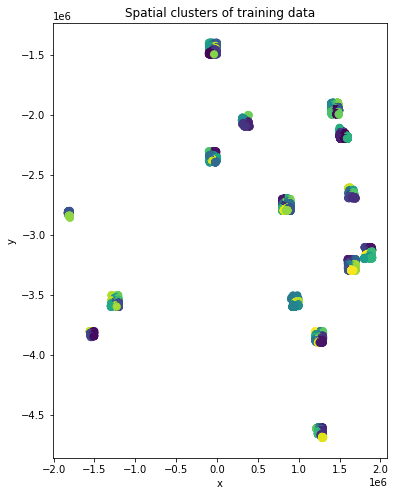

In [15]:
import sys
import os
import matplotlib.pyplot as plt
import pickle
import numpy as np 
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, f_classif
from sklearn.metrics import f1_score, balanced_accuracy_score
import joblib
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from itertools import compress
sys.path.append('/home/jovyan/Scripts')
from dea_classificationtools import spatial_clusters, SKCV, spatial_train_test_split

# Set up working dir
working_dir = '/home/jovyan/development/training_data/2015_merged//'
filename = os.path.join(working_dir, '2015_training_data_binary.txt')
model_input = np.loadtxt(filename, skiprows=1)
random_state = 1234
ncpus = 48

coordinates = model_input[:,-3:-1]

# Set up header and input features
with open(filename, 'r') as file:
    header = file.readline()
column_names = header.split()

column_names_indices = {}

for col_num, var_name in enumerate(column_names):
    column_names_indices[var_name] = col_num

model_variables = ['blue','red','green','nir','swir1','swir2','edev','sdev','bcdev', 'NDVI', 'MNDWI', 'BAI', 'BUI', 'BSI', 'TCG', 'TCW', 'TCB', 'NDMI', 'LAI', 'EVI', 'AWEI_sh', 'BAEI', 'NDSI', 'SAVI', 'NBR', 'BS_PC_10', 'PV_PC_10', 'NPV_PC_10' ,'BS_PC_50', 'PV_PC_50' ,'NPV_PC_50' ,'BS_PC_90', 'PV_PC_90', 'NPV_PC_90', 'chirps']

model_col_indices = []

for model_var in model_variables:
    model_col_indices.append(column_names_indices[model_var])

# Seperate dependent and independent variables
X = model_input[:,model_col_indices]
y = model_input[:,-1]
        
# Spatial k fold
outer_cv_splits = 2
inner_cv_splits = 2
test_size = 0.20
cluster_method = 'Hierarchical'
max_distance = 50000
n_clusters=None
kfold_method = 'SpatialKFold'
balance = 10
# Choose metric that reflects the tradeoffs desired in product
metric='f1'

#create clustes
spatial_groups = spatial_clusters(coordinates=coordinates,
        method=cluster_method,
        max_distance=max_distance,
        n_groups=n_clusters)

plt.figure(figsize=(6,8))
plt.scatter(coordinates[:,0], coordinates[:, 1], c=spatial_groups,
                    s=50, cmap='viridis');
plt.title('Spatial clusters of training data')
plt.ylabel('y')
plt.xlabel('x')
plt.savefig('spatialcluster.png')

# Modelling

# Feature selection using LASSO
#feature_selection = SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000))
feature_selection = SelectKBest(f_classif, k="all")

selected = np.array(model_variables)[feature_selection.fit(X,y).get_support()]

print(selected)

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=random_state, verbose=0,
                       )

# Hyperparameter grid to explore
param_grid = { 
            'max_depth': [20, 50, 100],
            'class_weight': [None, 'balanced', 'balanced_subsample'],
            'max_features': ['auto', 'sqrt'],
            # entropy is slightly slower to compute and should be similar in 98% of cases
            'criterion': ['gini'],
            'oob_score': ['True','False'],
#            'ccp_alpha': [0.0,0.25,0.5]
            }

# create outer k-fold splits
outer_cv = SKCV(
    coordinates=coordinates,
    max_distance=max_distance,
    n_splits=outer_cv_splits,
    cluster_method=cluster_method,
    kfold_method=kfold_method,
    test_size=test_size,
    balance=balance,
)
print(outer_cv)
# lists to store results of CV testing
acc = []
f1 = []
roc_auc = []
# loop through outer splits and test predictions
for train_index, test_index in outer_cv.split(coordinates):

    # index training, testing, and coordinate data
    X_tr, X_tt = X[train_index, :], X[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    coords = coordinates[train_index]
    # inner split on data within outer split
    inner_cv = SKCV(
        coordinates=coords,
        max_distance=max_distance,
        n_splits=inner_cv_splits,
        cluster_method=cluster_method,
        kfold_method=kfold_method,
        test_size=test_size,
        balance=balance,
    )
    
    #perform grid search on hyperparameters
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=metric,
        n_jobs=ncpus,
        cv=inner_cv.split(coords),
        refit=True,
    )
    
    clf.fit(X_tr, y_tr)
    #predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # ROC AUC
    probs = best_model.predict_proba(X_tt)
    probs = probs[:, 1]
#    fpr, tpr, thresholds = roc_curve(y_tt, probs)
#    auc_ = auc(fpr, tpr)
#    roc_auc.append(auc_)
    # Overall accuracy
    ac = balanced_accuracy_score(y_tt, pred)
    acc.append(ac)
    # F1 scores
    f1_ = f1_score(y_tt, pred)
    f1.append(f1_)

print("=== Nested Spatial K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: "+ str(round(np.mean(acc), 2)))
print("Std balanced accuracy: "+ str(round(np.std(acc), 2)))
#print('\n')
print("Mean F1: "+ str(round(np.mean(f1), 2)))

#generate n_splits of train-test_split
ss = SKCV(
        coordinates=coordinates,
        max_distance=max_distance,
        n_groups=n_clusters,
        n_splits=outer_cv_splits,
        cluster_method=cluster_method,
        kfold_method=kfold_method,
        test_size=test_size,
        balance=balance
        )


#instatiate a gridsearchCV
clf = GridSearchCV(model,
                   param_grid,
                   scoring=metric,
                   verbose=1,
                   cv=ss.split(coordinates),
                   n_jobs=ncpus)

#clf.fit(X, y)


#cv_model = GridSearchCV(estimator=model, param_grid=param_grid, cv= inner_cv, refit=True)

# Pipe selected features into hyper parameter search
pipe = Pipeline([('feature_selection', feature_selection),
        ('classification', clf)
        ])

# External CV to assess accuracy
#nested_score = cross_val_score(pipe, X=model_input[:,model_col_indices], y=model_input[:,25], cv=outer_cv, n_jobs = -1).mean()
#print("Nested score:",nested_score)

# Fit pipe
pipe.fit(X, y)

print("Number of features:", pipe['classification'].best_estimator_.n_features_, "/", len(model_variables))

model_variables = list(compress(model_variables, pipe['feature_selection'].get_support()))

# Variable importance
for var_name, var_importance in zip(model_variables, pipe['classification'].best_estimator_.feature_importances_):
    print("{}: {:.04}".format(var_name, var_importance))

print("The most accurate combination of tested parameters is: ")
print(pipe['classification'].best_params_)
print('\n')
print("The "+metric+" score using these parameters is: ")
print(round(pipe['classification'].best_score_, 2))

ml_model_dict = {}
ml_model_dict['variables'] = model_variables
ml_model_dict['classes'] = {'Cultivated' : 111,
                            'Not Cultivated' : 0}
ml_model_dict['classifier'] = clf.best_estimator_
## Save model
with open(os.path.join(working_dir, '2015_model.joblib'), 'wb') as f:
    joblib.dump(ml_model_dict, f)


In [17]:
from sklearn.feature_selection import SelectFromModel
best_model.feature_importances_

array([0.01738639, 0.02202582, 0.01682299, 0.03666692, 0.0164301 ,
       0.01798472, 0.10422168, 0.02939269, 0.03017827, 0.01980748,
       0.02568781, 0.03544789, 0.01380779, 0.01294463, 0.04509533,
       0.01331134, 0.03590219, 0.01584715, 0.03417802, 0.03446528,
       0.03032668, 0.02326927, 0.02946591, 0.02847918, 0.01332508,
       0.01041679, 0.03226355, 0.01479584, 0.02137573, 0.02415933,
       0.0102624 , 0.03025535, 0.03554763, 0.01692035, 0.10153242])